In [9]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import tiktoken
from datasets import load_dataset


from deeppy import Network, IngpData, LearnFrame, FromLoader
from deeppy.models.cv import Sane
from torch.utils.data import Dataset, DataLoader, random_split
import glob

import os

In [2]:
#LOAD HALF PRECISION ALWAYS

from deeppy.data.base import Base


from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import glob
import json
import numpy as np
import h5py


class IngpData(Dataset):
    def __init__(self, data_path, config, window_size = None, token_size = None, max_layer_width = 64,  augment = False):
        self.data_path = data_path
        self.config = config
        self.augment = augment

        

        self.window_size = window_size
        self.hash_chunk_size = self.window_size - 53 # 53 is the size of the MLP tokens
        self.token_size = token_size
        self.max_layer_width = max_layer_width

        if self.token_size % self.max_layer_width != 0:
            raise ValueError("Invalid token size or max_layer_width")
        
        self.load_object_paths()
        
        self.max_positions = self[0][1].max(axis=0).values + 1
        self.max_positions[2] = (self.hash_table_indices_end[-1]  - self.hash_table_indices_end[-2] ).item()


    def __len__(self):
        if self.augment:
            return len(self.all_objects)
        else:
            return len(self.all_objects_2d)
    def __add__(self):
        pass

    def __getitem__(self, idx):
        #Random index
        #Sample (window_size - hash_chunk_size )points in 3D space (512,3)

        #Turn them into hash indices (16 , 512, 8)
        # (16, 512*8)
        if self.augment:
            rand_ix = torch.randint(low=0, high=self.hash_table_indices_end[-1].item() - (self.hash_chunk_size), size=(1,)).item()
            indices = torch.arange(rand_ix, rand_ix + self.hash_chunk_size)
        else:
            raise ValueError("Not implemented for non-augment mode")

        if self.augment:
            path, transform = self.all_objects[idx]

            t1,p1,m1,a1 = self.get_object_sample(path, indices)
            r1 = transform["scene_info"]["current_rotation"]
            r1 = torch.deg2rad(torch.tensor(r1))

            #check if there is any none in returns
            if torch.any(torch.isnan(t1)) or torch.any(torch.isnan(p1)) or torch.any(torch.isnan(m1)) or torch.any(torch.isnan(r1)):
                print(f"NaN values found in object {path} at index {idx}")
                return None, None, None, None, None, None, None, None
            return t1, p1, m1, r1, a1, torch.clone(p1), torch.clone(m1), torch.clone(r1)
        else:
            object_parent_path = self.all_objects_2d[idx]
            idx_child = torch.randperm(len(object_parent_path))[:2] 
            obj1_path, obj_1_transform = object_parent_path[idx_child[0]]
            obj2_path, obj_2_transform = object_parent_path[idx_child[1]]

            t1,p1,m1,_ = self.get_object_sample(obj1, indices)
            r1 = obj_1_transform["scene_info"]["current_rotation"]
            r1 = torch.deg2rad(torch.tensor(r1))

            t2,p2,m2,_ = self.get_object_sample(obj2, indices)
            r2 = obj_2_transform["scene_info"]["current_rotation"]
            r2 = torch.deg2rad(torch.tensor(r2))

            #check if there is any none in returns
            if torch.any(torch.isnan(t1)) or torch.any(torch.isnan(p1)) or torch.any(torch.isnan(m1)) or torch.any(torch.isnan(r1)) or \
               torch.any(torch.isnan(t2)) or torch.any(torch.isnan(p2)) or torch.any(torch.isnan(m2)) or torch.any(torch.isnan(r2)):
                print(f"NaN values found in object {obj1_path} or {obj2_path} at index {idx}")
                return None, None, None, None, None, None, None, None
            return t1, p1, m1, r1, t2, p2, m2, r2

    def get_object_sample(self, obj_path, indices):
        

        #(hash_chunk_size, token_size)
        hash_t, hash_p, hash_m, hash_aug = self.load_hash_consecutive(obj_path, indices)
        
        #(window_size - hash_chunk_size, token_size)
        mlp, mlp_aug = self.load_mlp_weights(obj_path)        
        mlp_t, mlp_p, mlp_m = mlp
        mlp_p[:,0] = torch.arange(self.hash_table_indices_end[-1].item()+1, self.hash_table_indices_end[-1].item()+1 + len(mlp_p[:,2]))  # Set position indices for MLP tokens

        return torch.vstack([hash_t, mlp_t]), torch.vstack([hash_p, mlp_p]), torch.vstack([hash_m, mlp_m]), torch.vstack([hash_aug, mlp_aug])
    

    def load_hash_consecutive(self, path, global_indices):
        layers = torch.searchsorted(self.hash_table_indices_end, global_indices, right=True)
        local_starts = self.hash_table_indices_start[layers]

        # Local index is just offset from start
        local_indices = (global_indices - local_starts) * (self.token_size // 2)

        pos = torch.stack([global_indices,layers, local_indices/ (self.token_size // 2)]).T.to(dtype=torch.int64)  # (num_points, 2)

        unique_layers = torch.unique(layers)
        tokens, masks = [], []

        for layer in unique_layers:
            mask = (layers == layer)
            indices = local_indices[mask]  # All sub-indices for this layer
            
            with h5py.File(path, 'r') as f:
                dset = f[f"level_{layer.item()}"]
                chunk = torch.from_numpy(dset[indices[0] : indices[-1] + (self.token_size // 2)])  # Load the entire chunk
            
            mask = torch.ones_like(chunk)
            n_layers_per_token = (self.token_size // 2) 
            pad_axis_0 = (n_layers_per_token - (chunk.shape[0] % n_layers_per_token)) % n_layers_per_token
            if pad_axis_0 > 0:
                chunk = torch.cat([chunk, torch.zeros(pad_axis_0, chunk.shape[1])], dim=0) 
                mask = torch.cat([mask, torch.zeros(pad_axis_0, mask.shape[1])], dim=0)
            
            tokens.append(chunk)
            masks.append(mask)
        tokens = torch.cat(tokens, dim=0)  # Concatenate all layers
        tokens = tokens.reshape(-1, self.token_size)  # Reshape to

        masks = torch.cat(masks, dim=0)  # Concatenate all masks
        masks = masks.reshape(-1, self.token_size)  # Reshape to match tokens


        return tokens, pos, masks, self.augment_layer(tokens)

    def load_hash_every_layer(self, path, indices):
        """
        indices : (num_layers, num_points * 8) Tensor / numpy array
        """
        #(16,512*8)
        return_data = []
        with h5py.File(path, 'r') as f:
            for i,ix in enumerate(indices):
                dset = f[f"level_{i}"] 
                #sort
                indices = np.sort(ix)
                chunk = torch.from_numpy(dset[indices]) # (512*8,2)
                chunk = chunk.reshape(-1,8,2) #(512,8,2)
                return_data.append(chunk)
        
        return_data = torch.stack(return_data) #(16,512,8,2)
        #turn it to (512,8,16,2) and then flatten to (512,256)
        token = return_data.permute(1,2,0,3).reshape(-1, self.token_size)
        augmented = None
        if self.augment:
            augmented = self.augment_layer(token)
        mask = torch.ones_like(token)
        #(1,256)
        pos = torch.randint(0,512,size = (token.shape[0],2))

        return token, pos, mask, augmented
    
    def load_hash_info(self):
        hash_table_indices = []
        with h5py.File(self.all_objects[0][0], 'r') as f:
            for i in range(16):
                hash_table_indices.append(f[f"level_{i}"].shape[0])
        hash_table_indices = torch.ceil(torch.tensor(hash_table_indices) / (self.token_size // 2))
        self.hash_table_indices_end = torch.cumsum(hash_table_indices, dim=0).to(dtype=torch.int)
        self.hash_table_indices_start = torch.cat([torch.tensor([0]), self.hash_table_indices_end[:-1]])
    def load_object_paths(self):
        self.objects = glob.glob(self.data_path + "/*")
        self.all_objects_2d = []
        self.all_objects = []
        for o in self.objects:
            objs_path = glob.glob(o + "/*")
            this_object = []
            for in_obj in objs_path:

                with open(in_obj + "/transforms.json", "r") as file:
                    transform = json.load(file)
                    del transform["frames"]
                data = (in_obj + "/checkpoints/final.h5",transform)
                this_object.append(data)
                self.all_objects.append(data)
            self.all_objects_2d.append(this_object)
        self.load_hash_info()
    

    def load_mlp_weights(self,path):
        """Load MLP weights from a file and tokenize them into layers.  
        Args:
            path (str): Path to the HDF5 file containing weights.
        Returns:
            list: A list of tokenized MLP layers, each represented as a tensor.
        """
        geometry_layers, view_layers = [], []
        augmented_geometry_layers, augmented_view_layers = [], []
        
        with h5py.File(path, 'r') as f:
            for i in range(3):
                dset1, dset2= f[f"geo_layer_{i}"], f[f"view_layer_{i}"]
                chunk1 = torch.from_numpy(dset1[:])
                chunk2 = torch.from_numpy(dset2[:])

                if self.augment:
                    augment1 = self.augment_layer(chunk1)
                    augment2 = self.augment_layer(chunk2)

                    augmented_geometry_layers.append(self.tokenize_mlp_layer(augment1, layer_ix= i + 16))
                    augmented_view_layers.append(self.tokenize_mlp_layer(augment2, layer_ix= i + 16 + 3))
                # Tokenize each layer
                geometry_layers.append(self.tokenize_mlp_layer(chunk1, layer_ix= i + 16))
                view_layers.append(self.tokenize_mlp_layer(chunk2, layer_ix= i + 16 + 3))

        #(6 , X , token_size) -> (1, 6X, token_size)
        layers = geometry_layers + view_layers
        layers = [torch.vstack(k) for k in zip(*layers)]

        if self.augment:
            augmented_layers = augmented_geometry_layers + augmented_view_layers
            augmented_layers = [torch.vstack(k) for k in zip(*augmented_layers)]
        return layers, augmented_layers[0]
        
    def tokenize_mlp_layer(self, w, layer_ix = None):
        pad = self.max_layer_width - w.shape[1]
        mask = torch.ones_like(w)
        
        # w - > (x , max_layer_width)
        if pad > 0:
            w = nn.functional.pad(w, (0, pad))
            mask = nn.functional.pad(mask, (0,pad))

        n_layers_per_token = (self.token_size // self.max_layer_width)
        pad_axis_0 = (n_layers_per_token - (w.shape[0] % n_layers_per_token)) % n_layers_per_token
        
        # (x, max_layer_width) -> (n_layers_per_token *k , max_layer_width)
        if pad_axis_0 > 0:
            w = torch.cat([w, torch.zeros(pad_axis_0, w.shape[1])], dim=0)
            mask = torch.cat([mask, torch.zeros(pad_axis_0, mask.shape[1])], dim=0)

        #(Group each 4 rows into one row)
        w = w.view(-1, n_layers_per_token , self.max_layer_width).view(-1,self.token_size)
        mask = mask.view(-1, n_layers_per_token , self.max_layer_width).view(-1,self.token_size)
        
        pos = torch.zeros((w.shape[0], 3), dtype=torch.int64)
        pos[:,1] = torch.full_like(pos[:,0], layer_ix)
        pos[:,2] = torch.arange(w.shape[0])
        return w,pos,mask

    def augment_layer(self, w):
        """Apply data augmentation to a single MLP layer."""
        # Example augmentation: add noise
        noise = 0.01 * torch.randn_like(w)
        return w + noise



In [10]:


data_config = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

window_size = 512
batch_size = 16
input_dim = 256

data = IngpData(data_path="../../data/", config = data_config, window_size=window_size, token_size = input_dim, augment=True)
#print(data.token_size)
#print(data.max_positions)

dloader = DataLoader(data, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle = True)

ddata = FromLoader(train_loader=dloader)
len(data)

534

In [4]:

embed_dim = 1024
latent_dim = 128
num_heads = 8
num_layers = 8
window_size = window_size
max_positions = data.max_positions
dropout = 0.1
bias = False
projection_dim = 10


total_epocs = 50

In [5]:
n_object = len(data.all_objects)
n_param = 7e6
t_param = n_object * n_param

pass_param = (window_size - 50) * (input_dim / 2) * batch_size



epochs = int(t_param/pass_param) * total_epocs
epochs

197500

In [6]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 100.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.45],
    "ntx_temp" : 0.1,
    "torch_compile" : True,
    "amp":True,

}

model = dp.cv.Sane(**Sane_params)

Process ForkProcess-21:
Process ForkProcess-17:
Process ForkProcess-20:
Process ForkProcess-19:
Process ForkProcess-13:
Process ForkProcess-23:
Process ForkProcess-14:
Process ForkProcess-9:
Process ForkProcess-11:
Process ForkProcess-22:
Process ForkProcess-24:
Process ForkProcess-18:
Process ForkProcess-16:
Process ForkProcess-15:
Process ForkProcess-10:
Process ForkProcess-12:
Process ForkProcess-8:
Process ForkProcess-4:
Process ForkProcess-7:
Process ForkProcess-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-1:
Process ForkProcess-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
 

  File "/home/baris/anaconda3/envs/rl/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/process.py", line 108, in 

  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/connection.py", line 413, in _recv_bytes
    buf = self._recv(4)
          ^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/baris/anaconda3/envs/rl/lib/python3.11/multiprocessing/synchroni

# Create A LearnFrame

In [7]:
lf = LearnFrame(model,ddata)

# Train a Batch

<Figure size 640x480 with 0 Axes>

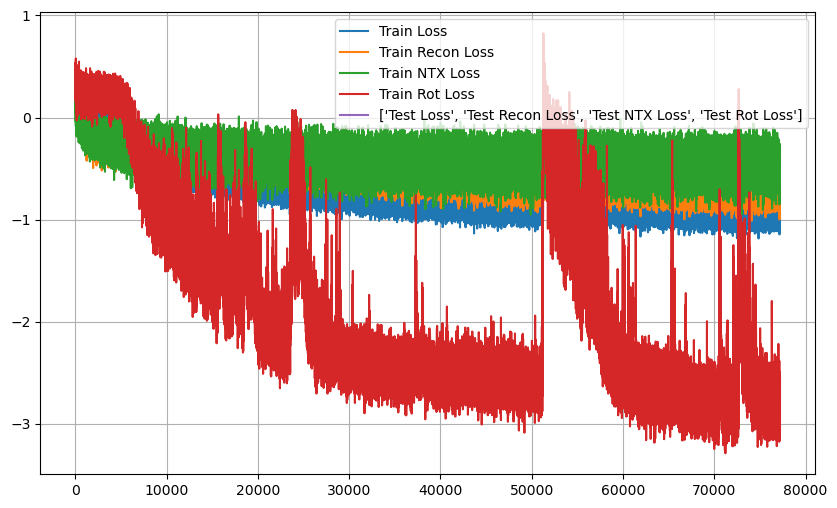

<Figure size 640x480 with 0 Axes>

In [ ]:
path = "checkpoints/sane/"

for i in range(lf.optim_epoch,epochs):
    lf.optimize()
    if i%100 == 0:
        lf.plot(show_result = False, log = True)
    
    if i % 5000 == 0 and i > 1:
        dire = path + f"{i}"
        
        try:
            os.mkdir(dire)
        except:
            pass
        lf.save(dire)
        
lf.plot(show_result = True, log = True)

In [ ]:
dire = path + "final"
try:
    os.mkdir(dire)
except:
    pass
lf.save(dire)

In [28]:
lf.metric.train_data

[(1.7897385358810425, 1.69232177734375, 1.498923897743225, 3.834056854248047),
 (1.6131023168563843,
  1.5510294437408447,
  1.8136260509490967,
  2.5298900604248047),
 (1.6970734596252441,
  1.6112769842147827,
  1.925641417503357,
  3.012840747833252),
 (1.6470173597335815,
  1.57582426071167,
  1.4785157442092896,
  3.0969979763031006),
 (1.7412978410720825,
  1.6730412244796753,
  1.6067408323287964,
  3.1044747829437256),
 (1.620491862297058,
  1.590592384338379,
  1.2971299886703491,
  2.4820456504821777),
 (1.5380898714065552,
  1.5161845684051514,
  1.3424056768417358,
  2.12807035446167),
 (1.601660966873169,
  1.5327661037445068,
  1.3704007863998413,
  3.073029041290283),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, nan, nan, nan),
 (nan, na

# Test a Batch

In [15]:
lf.test()
print(f"Loss train : {lf.metric.test_data[-1]}")

Loss train : 2.5419931411743164


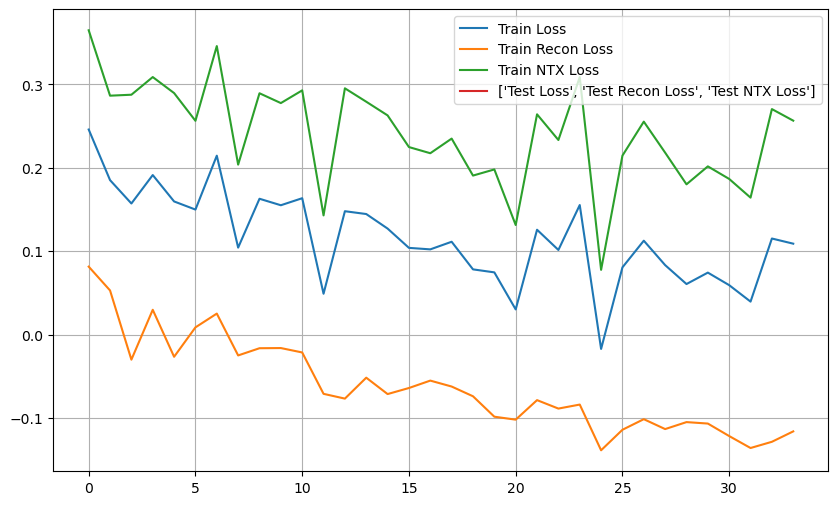

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
lf.plot(show_result = True, log = True)

In [7]:
import time

# Test

In [6]:
def optimize_test_time(model):
    cout = window_size
    cr = input_dim

    tokenized_input = torch.rand(size = (batch_size, cout, cr)).to(device)
    mask = torch.ones(size = tokenized_input.size()).to(device)
    positions = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

    tokenized_input2 = torch.rand(size = (batch_size, cout, cr)).to(device)
    mask2 = torch.ones(size = tokenized_input.size()).to(device)
    positions2 = torch.randint(0,500, size = (batch_size,cout,3)).to(device)

    rots = torch.rand(size = (batch_size,3)).to(device)

    start_event = torch.cuda.Event(enable_timing=True)

    model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))



## Vanilla

In [10]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : False,
    "amp":False,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))



(1.5559914112091064, 1.3085711002349854, 7.043848514556885, 0.5217000842094421)

In [11]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

optimize_test_time(model)

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

Elapsed time: 0.094703 seconds


## Torch compile

In [7]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : True,
    "amp":False,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))


(1.3616125583648682, 1.1827006340026855, 5.274228096008301, 0.6694096326828003)

In [11]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

n_times = 100
for i in range(n_times):
    optimize_test_time(model)

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event) / n_times  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

Elapsed time: 1.152807 seconds


## AMP

In [6]:
scheduler_config = {
   
}

Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": 3e-4,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": False,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 3e-4, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 500.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.05],
    "ntx_temp" : 0.1,
    "torch_compile" : False,
    "amp":True,

}

model = dp.cv.Sane(**Sane_params)
model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))


tensor(1.4955, device='cuda:0', grad_fn=<AddBackward0>)


AssertionError: No inf checks were recorded prior to update.

In [ ]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()

for i in range(100):
    model.optimize((tokenized_input, positions, mask, tokenized_input, positions2, mask2, rots))

end_event.record()

# Waits for everything to finish running
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)  # milliseconds
print(f"Elapsed time: {elapsed_time_ms / 1000:.6f} seconds")

In [15]:
model.optimizer.scaler.is_enabled()

True